# Dermatologist-AI Project: Single Network Approach
Workbook for a single network approach that classifies images into melanomas, nevus, or SBK

### Set up and process data

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
from keras.preprocessing import image                  
from keras.applications.vgg19 import preprocess_input
from tqdm import tqdm
from PIL import ImageFile                            
import os
import pickle
ImageFile.LOAD_TRUNCATED_IMAGES = True      

# define two-category encoding utility function
def two_category_one_hot(labels, flag_index):
    '''
    Convert a multi-category array of labels into a one-hot encoding of two categories only:
    the one to identify, and everything else
    labels:: 1D numpy array of labels
    flag_index:: index of the category that will be tagged as 1. All other categories will be recoded as 0
    '''
    encoding = np.empty((0,2), 'float32')

    for ii in range(len(labels)):
        if labels[ii] == flag_index:
            encoding = np.append(encoding,np.array([[1.,0.]]), axis=0)
        else:
            encoding = np.append(encoding,np.array([[0.,1.]]), axis=0)
    return encoding

# define function to load train, test, and validation datasets
def load_dataset(path, shuffle):
    data = load_files(path, shuffle=shuffle)
    file_paths = np.array(data['filenames'])
    ML_labels = two_category_one_hot(np.array(data['target']),0)
    SK_labels = two_category_one_hot(np.array(data['target']),2)
    return file_paths, ML_labels, SK_labels

# define functions to convert images into 4D tensors for convnets
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    x = preprocess_input(x)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors) 

# define function to decide whether to load tensors from a saved pickle or raw images
def load_tensors_and_labels(pickle_file, raw_file_path, shuffle, force=False):
    pickle_file = os.path.join('.', pickle_file)
 
    if force or not os.path.exists(pickle_file):
        files, ML_labels, SK_labels = load_dataset(raw_file_path, shuffle)
        tensors = paths_to_tensor(files).astype('float32')/255
        with open(pickle_file, 'wb') as handle:
            pickle.dump([tensors, ML_labels, SK_labels], handle, protocol=pickle.HIGHEST_PROTOCOL)
        return tensors, ML_labels, SK_labels

    else:        
        with open(pickle_file, 'rb') as handle:
            tensors, ML_labels, SK_labels = pickle.load(handle)        
        return tensors, ML_labels, SK_labels
    

Using TensorFlow backend.


In [2]:
# Load data

train_tensors, train_ML_labels, train_SK_labels = load_tensors_and_labels('train_data_ensemble.pickle','../data/train', True)
valid_tensors, valid_ML_labels, valid_SK_labels = load_tensors_and_labels('valid_data_ensemble.pickle','../data/valid', True)
test_tensors, test_ML_labels, test_SK_labels = load_tensors_and_labels('test_data_ensemble.pickle','../data/test', False)


In [3]:
import pandas as pd
train_ML_data = pd.DataFrame(train_ML_labels)
valid_ML_data = pd.DataFrame(valid_ML_labels)
test_ML_data = pd.DataFrame(test_ML_labels)

print(train_ML_data.sum(axis=0))
print(valid_ML_data.sum(axis=0))
print(test_ML_data.sum(axis=0))


0     840.0
1    2365.0
dtype: float64
0     30.0
1    120.0
dtype: float64
0    117.0
1    483.0
dtype: float64


In [4]:
train_SK_data = pd.DataFrame(train_SK_labels)
valid_SK_data = pd.DataFrame(valid_SK_labels)
test_SK_data = pd.DataFrame(test_SK_labels)

print(train_SK_data.sum(axis=0))
print(valid_SK_data.sum(axis=0))
print(test_SK_data.sum(axis=0))

0     286.0
1    2919.0
dtype: float64
0     42.0
1    108.0
dtype: float64
0     90.0
1    510.0
dtype: float64


## Build melanoma detection model
Melanoma model based on four three layers of VGG19 followed by trainable convnet and dense layers

In [5]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

MLmodel = Sequential()

#First 4 blocks of VGG19
MLmodel.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', trainable=False, name='block1_conv1', 
                        input_shape=(224, 224, 3)))
MLmodel.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', trainable=False, name='block1_conv2'))
MLmodel.add(MaxPooling2D(pool_size=2, name='block1_pool'))
MLmodel.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', trainable=False, name='block2_conv1'))
MLmodel.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', trainable=False, name='block2_conv2'))
MLmodel.add(MaxPooling2D(pool_size=2, name='block2_pool'))
MLmodel.add(Dropout(0.1))
MLmodel.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', trainable=False, name='block3_conv1'))
MLmodel.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', trainable=False, name='block3_conv2'))
MLmodel.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', trainable=False, name='block3_conv3'))
MLmodel.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', trainable=False, name='block3_conv4'))
MLmodel.add(MaxPooling2D(pool_size=2, name='block3_pool'))
MLmodel.add(Dropout(0.1))
MLmodel.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', trainable=False, name='block4_conv1'))
MLmodel.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', trainable=False, name='block4_conv2'))
MLmodel.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', trainable=False, name='block4_conv3'))
MLmodel.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', trainable=False, name='block4_conv4'))
MLmodel.add(MaxPooling2D(pool_size=2, name='block4_pool'))

#First 1 trainable convnet block
MLmodel.add(Dropout(0.1))
MLmodel.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', trainable=True, name='block5_conv1'))
MLmodel.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', trainable=True, name='block5_conv2'))
MLmodel.add(MaxPooling2D(pool_size=2, name='block5_pool'))
MLmodel.add(Dropout(0.2))

#Trainable dense layers
MLmodel.add(Flatten())
MLmodel.add(Dense(512, activation='relu'))
MLmodel.add(Dropout(0.2))
MLmodel.add(Dense(256, activation='relu'))
MLmodel.add(Dropout(0.2))
MLmodel.add(Dense(2, activation='softmax'))

MLmodel.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 128)       0         
__________

Import and assign VGG19 weights

In [6]:
from keras import optimizers
opt = optimizers.rmsprop(lr=0.00007, decay=1e-6)
MLmodel.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
from keras import applications
import h5py

weights_path = 'vgg19_weights.h5'
f = h5py.File(weights_path, 'r')

VGGnet_layers = ['block1_conv1',
                 'block1_conv2',
                 'block2_conv1',
                 'block2_conv2',
                 'block3_conv1',
                 'block3_conv2',
                 'block3_conv3',
                 'block3_conv4',
                 'block4_conv1',
                 'block4_conv2',
                 'block4_conv3',
                 'block4_conv4']
layer_names = [layer.name for layer in MLmodel.layers]

for i in VGGnet_layers:
    weight_names = f[i].attrs["weight_names"]    
    weights = [f[i][j] for j in weight_names]
    index = layer_names.index(i)
    MLmodel.layers[index].set_weights(weights)


Set up data augmentation functions

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    rotation_range=30, # randomly rotate images up to 30 degrees
    zoom_range=0.1, # randomly zoom in and out by 10%
    horizontal_flip=True) # randomly flip images horizontally

# create and configure augmented image generator
datagen_valid = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    rotation_range=30, # randomly rotate images up to 30 degrees
    zoom_range=0.1, # randomly zoom in and out by 10%
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen_train.fit(train_tensors)
datagen_valid.fit(valid_tensors)

In [9]:
from keras.callbacks import ModelCheckpoint  

epochs = 20

checkpointer = ModelCheckpoint(filepath='saved_models/weightsML.hdf5', 
                               verbose=1, save_best_only=True)

MLmodel.fit_generator(datagen_train.flow(train_tensors, train_labels, batch_size=20),
                    steps_per_epoch=train_tensors.shape[0] // 20,
                    epochs=epochs, verbose=1, callbacks=[checkpointer],
                    validation_data=datagen_valid.flow(valid_tensors, valid_ML_labels, batch_size=20),
                    validation_steps=valid_tensors.shape[0] // 20)


#MLmodel.fit(train_tensors, train_ML_labels,
#            validation_data=(valid_tensors, valid_ML_labels),
#            epochs=epochs,
#            batch_size=20,
#            callbacks=[checkpointer],
#            verbose=1)

Train on 3205 samples, validate on 150 samples
Epoch 1/20
3205/3205 [==============================] - 54s - loss: 0.7239 - acc: 0.7073 - val_loss: 0.5866 - val_acc: 0.8000
Epoch 2/20


3205/3205 [==============================] - 50s - loss: 0.5349 - acc: 0.7495 - val_loss: 0.4918 - val_acc: 0.8000
Epoch 3/20


3205/3205 [==============================] - 50s - loss: 0.4936 - acc: 0.7757 - val_loss: 0.4839 - val_acc: 0.8133
Epoch 4/20


3205/3205 [==============================] - 50s - loss: 0.4394 - acc: 0.8037 - val_loss: 0.5197 - val_acc: 0.8000
Epoch 5/20


3205/3205 [==============================] - 50s - loss: 0.4029 - acc: 0.8184 - val_loss: 0.6963 - val_acc: 0.5667
Epoch 6/20


3205/3205 [==============================] - 51s - loss: 0.3705 - acc: 0.8365 - val_loss: 0.4790 - val_acc: 0.7800
Epoch 7/20


3205/3205 [==============================] - 52s - loss: 0.3173 - acc: 0.8721 - val_loss: 0.4846 - val_acc: 0.8067
Epoch 8/20


3205/3205 [==============================] - 51s - loss: 0.2914 - acc: 0.8777 - val_loss: 0.7638 - val_acc: 0.8400
Epoch 9/20


3205/3205 [==============================] - 51s - loss: 0.2529 - acc: 0.8986 - val_loss: 0.6262 - val_acc: 0.8067
Epoch 10/20


3205/3205 [==============================] - 51s - loss: 0.2329 - acc: 0.9036 - val_loss: 0.6516 - val_acc: 0.8533
Epoch 11/20


3205/3205 [==============================] - 52s - loss: 0.2162 - acc: 0.9145 - val_loss: 0.5342 - val_acc: 0.8267
Epoch 12/20


3205/3205 [==============================] - 51s - loss: 0.1831 - acc: 0.9261 - val_loss: 0.8033 - val_acc: 0.8200
Epoch 13/20


3205/3205 [==============================] - 51s - loss: 0.1647 - acc: 0.9301 - val_loss: 1.0406 - val_acc: 0.8533
Epoch 14/20


3205/3205 [==============================] - 54s - loss: 0.1497 - acc: 0.9429 - val_loss: 0.7282 - val_acc: 0.7733
Epoch 15/20


3205/3205 [==============================] - 51s - loss: 0.1367 - acc: 0.9454 - val_loss: 1.1738 - val_acc: 0.8467
Epoch 16/20


3205/3205 [==============================] - 51s - loss: 0.1322 - acc: 0.9482 - val_loss: 0.7176 - val_acc: 0.7800
Epoch 17/20


3205/3205 [==============================] - 51s - loss: 0.1217 - acc: 0.9576 - val_loss: 0.9664 - val_acc: 0.8133
Epoch 18/20


3205/3205 [==============================] - 51s - loss: 0.1077 - acc: 0.9588 - val_loss: 1.0166 - val_acc: 0.8600
Epoch 19/20


3205/3205 [==============================] - 51s - loss: 0.1009 - acc: 0.9629 - val_loss: 1.2645 - val_acc: 0.8400
Epoch 20/20


3205/3205 [==============================] - 51s - loss: 0.1012 - acc: 0.9604 - val_loss: 0.9755 - val_acc: 0.8600


## Build SK detection model
SK model based on four three layers of VGG19 followed by trainable convnet and dense layers

In [10]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

SKmodel = Sequential()

#First 4 blocks of VGG19
SKmodel.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', trainable=False, name='block1_conv1', 
                        input_shape=(224, 224, 3)))
SKmodel.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', trainable=False, name='block1_conv2'))
SKmodel.add(MaxPooling2D(pool_size=2, name='block1_pool'))
SKmodel.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', trainable=False, name='block2_conv1'))
SKmodel.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', trainable=False, name='block2_conv2'))
SKmodel.add(MaxPooling2D(pool_size=2, name='block2_pool'))
SKmodel.add(Dropout(0.1))
SKmodel.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', trainable=False, name='block3_conv1'))
SKmodel.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', trainable=False, name='block3_conv2'))
SKmodel.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', trainable=False, name='block3_conv3'))
SKmodel.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', trainable=False, name='block3_conv4'))
SKmodel.add(MaxPooling2D(pool_size=2, name='block3_pool'))
SKmodel.add(Dropout(0.1))
SKmodel.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', trainable=False, name='block4_conv1'))
SKmodel.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', trainable=False, name='block4_conv2'))
SKmodel.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', trainable=False, name='block4_conv3'))
SKmodel.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', trainable=False, name='block4_conv4'))
SKmodel.add(MaxPooling2D(pool_size=2, name='block4_pool'))

#First 1 trainable convnet block
SKmodel.add(Dropout(0.1))
SKmodel.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', trainable=True, name='block5_conv1'))
SKmodel.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', trainable=True, name='block5_conv2'))
SKmodel.add(MaxPooling2D(pool_size=2, name='block5_pool'))
SKmodel.add(Dropout(0.2))

#Trainable dense layers
SKmodel.add(Flatten())
SKmodel.add(Dense(512, activation='relu'))
SKmodel.add(Dropout(0.1))
SKmodel.add(Dense(128, activation='relu'))
SKmodel.add(Dropout(0.1))
SKmodel.add(Dense(2, activation='softmax'))

SKmodel.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 56, 56, 128)       0         
__________

In [11]:
from keras import optimizers
opt = optimizers.rmsprop(lr=0.00007, decay=1e-6)
SKmodel.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
from keras import applications
import h5py

weights_path = 'vgg19_weights.h5'
f = h5py.File(weights_path, 'r')

VGGnet_layers = ['block1_conv1',
                 'block1_conv2',
                 'block2_conv1',
                 'block2_conv2',
                 'block3_conv1',
                 'block3_conv2',
                 'block3_conv3',
                 'block3_conv4',
                 'block4_conv1',
                 'block4_conv2',
                 'block4_conv3',
                 'block4_conv4']
layer_names = [layer.name for layer in SKmodel.layers]

for i in VGGnet_layers:
    weight_names = f[i].attrs["weight_names"]    
    weights = [f[i][j] for j in weight_names]
    index = layer_names.index(i)
    SKmodel.layers[index].set_weights(weights)

In [13]:
from keras.callbacks import ModelCheckpoint  

epochs = 20

checkpointer = ModelCheckpoint(filepath='saved_models/weightsSK.hdf5', 
                               verbose=1, save_best_only=True)

SKmodel.fit_generator(datagen_train.flow(train_tensors, train_labels, batch_size=20),
                    steps_per_epoch=train_tensors.shape[0] // 20,
                    epochs=epochs, verbose=1, callbacks=[checkpointer],
                    validation_data=datagen_valid.flow(valid_tensors, valid_SK_labels, batch_size=20),
                    validation_steps=valid_tensors.shape[0] // 20)


#SKmodel.fit(train_tensors, train_SK_labels,
#            validation_data=(valid_tensors, valid_SK_labels),
#            epochs=epochs,
#            batch_size=20,
#            callbacks=[checkpointer],
#            verbose=1)

Train on 3205 samples, validate on 150 samples
Epoch 1/20
3205/3205 [==============================] - 51s - loss: 0.6416 - acc: 0.8945 - val_loss: 0.5530 - val_acc: 0.7200
Epoch 2/20


3205/3205 [==============================] - 51s - loss: 0.2410 - acc: 0.9136 - val_loss: 0.4583 - val_acc: 0.7267
Epoch 3/20


3205/3205 [==============================] - 50s - loss: 0.2027 - acc: 0.9226 - val_loss: 0.8825 - val_acc: 0.7733
Epoch 4/20


3205/3205 [==============================] - 50s - loss: 0.1789 - acc: 0.9279 - val_loss: 0.3991 - val_acc: 0.7867
Epoch 5/20


3205/3205 [==============================] - 50s - loss: 0.1590 - acc: 0.9335 - val_loss: 0.5484 - val_acc: 0.6600
Epoch 6/20


3205/3205 [==============================] - 50s - loss: 0.1491 - acc: 0.9395 - val_loss: 0.3561 - val_acc: 0.7933
Epoch 7/20


3205/3205 [==============================] - 50s - loss: 0.1424 - acc: 0.9441 - val_loss: 0.9887 - val_acc: 0.7733
Epoch 8/20


3205/3205 [==============================] - 50s - loss: 0.1307 - acc: 0.9560 - val_loss: 0.4335 - val_acc: 0.8067
Epoch 9/20


3205/3205 [==============================] - 50s - loss: 0.1157 - acc: 0.9560 - val_loss: 0.3514 - val_acc: 0.8533
Epoch 10/20


3205/3205 [==============================] - 50s - loss: 0.1099 - acc: 0.9548 - val_loss: 0.3470 - val_acc: 0.8133
Epoch 11/20


3205/3205 [==============================] - 50s - loss: 0.1043 - acc: 0.9635 - val_loss: 0.5994 - val_acc: 0.7933
Epoch 12/20


3205/3205 [==============================] - 50s - loss: 0.1013 - acc: 0.9663 - val_loss: 0.5443 - val_acc: 0.8133
Epoch 13/20


3205/3205 [==============================] - 50s - loss: 0.0794 - acc: 0.9676 - val_loss: 0.4820 - val_acc: 0.8267
Epoch 14/20


3205/3205 [==============================] - 50s - loss: 0.0846 - acc: 0.9682 - val_loss: 0.4776 - val_acc: 0.8533
Epoch 15/20


3205/3205 [==============================] - 50s - loss: 0.0710 - acc: 0.9732 - val_loss: 0.3303 - val_acc: 0.8333
Epoch 16/20


3205/3205 [==============================] - 50s - loss: 0.0765 - acc: 0.9735 - val_loss: 0.5575 - val_acc: 0.8000
Epoch 17/20


3205/3205 [==============================] - 50s - loss: 0.0697 - acc: 0.9750 - val_loss: 0.3799 - val_acc: 0.8600
Epoch 18/20


3205/3205 [==============================] - 50s - loss: 0.0557 - acc: 0.9797 - val_loss: 0.5004 - val_acc: 0.8667
Epoch 19/20


3205/3205 [==============================] - 50s - loss: 0.0684 - acc: 0.9822 - val_loss: 0.3051 - val_acc: 0.8667
Epoch 20/20


3205/3205 [==============================] - 50s - loss: 0.0464 - acc: 0.9825 - val_loss: 0.3323 - val_acc: 0.8867


## Create output .csv for testing

In [14]:
# Load the ML model weights with the best validation loss.

MLmodel.load_weights('saved_models/weightsML.hdf5')

In [15]:
# Load the SK model weights with the best validation loss.

SKmodel.load_weights('saved_models/weightsSK.hdf5')

In [21]:
import pandas as pd

y_pred = pd.DataFrame(columns=["task_1", "task_2"])

for ii in tqdm(range(len(test_tensors))):
    #path = test_files[ii]
    ML_prediction = np.argmax(MLmodel.predict(np.expand_dims(test_tensors[ii], axis=0)))
    SK_prediction = np.argmax(SKmodel.predict(np.expand_dims(test_tensors[ii], axis=0)))
    y_pred.loc[ii] = [0, 0]
    if ML_prediction == 1:
        y_pred.loc[ii]['task_1'] = 1
    if SK_prediction == 1:
        y_pred.loc[ii]['task_2'] = 1


y_pred.to_csv("predictions.csv")

## Internal testing vs. ground truths

In [22]:
import itertools
import keras
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_curve, auc, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator

def plot_roc_auc(y_true, y_pred):
    """
    This function plots the ROC curves and provides the scores.
    """

    # initialize dictionaries and array
    fpr = dict()
    tpr = dict()
    roc_auc = np.zeros(3)
    
    # prepare for figure
    plt.figure()
    colors = ['aqua', 'cornflowerblue']

    # for both classification tasks (categories 1 and 2)
    for i in range(2):
        # obtain ROC curve
        fpr[i], tpr[i], _ = roc_curve(y_true[:,i], y_pred[:,i])
        # obtain ROC AUC
        roc_auc[i] = auc(fpr[i], tpr[i])
        # plot ROC curve
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                 label='ROC curve for task {d} (area = {f:.2f})'.format(d=i+1, f=roc_auc[i]))
    # get score for category 3
    roc_auc[2] = np.average(roc_auc[:2])
    
    # format figure
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves')
    plt.legend(loc="lower right")
    plt.show()
    
    # print scores
    for i in range(3):
        print('Category {d} Score: {f:.3f}'. format(d=i+1, f=roc_auc[i]))

def plot_confusion_matrix(y_true, y_pred, thresh, classes):
    """
    This function plots the (normalized) confusion matrix.
    """

    # obtain class predictions from probabilities
    y_pred = (y_pred>=thresh)*1
    # obtain (unnormalized) confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # normalize confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

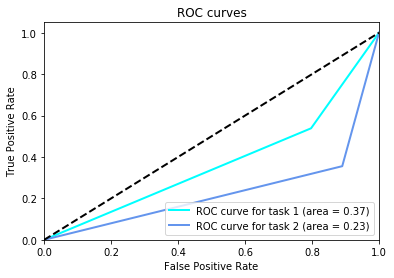

Category 1 Score: 0.371
Category 2 Score: 0.233
Category 3 Score: 0.302


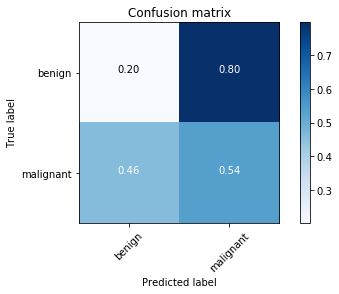

In [23]:
preds_path = sys.argv[1]
thresh = 0.5

# get ground truth labels for test dataset
truth = pd.read_csv('ground_truth.csv')
y_true = truth.as_matrix(columns=["task_1", "task_2"])

# get model predictions for test dataset
y_pred = pd.read_csv("predictions.csv")
y_pred = y_pred.as_matrix(columns=["task_1", "task_2"])

# plot ROC curves and print scores
plot_roc_auc(y_true, y_pred)
# plot confusion matrix
classes = ['benign', 'malignant']
plot_confusion_matrix(y_true[:,0], y_pred[:,0], thresh, classes)
